### Implementing a GPT-like transformer

In [1]:
import torch
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tiktoken

#### SOURCE: [Raschka, Sebastian. Build a Large Language Model (From Scratch). Simon and Schuster, 2024.](https://www.simonandschuster.com/books/Build-a-Large-Language-Model-From-Scratch/Sebastian-Raschka/9781394200867)

In [2]:
tokenizer = tiktoken.get_encoding('gpt2')

In [3]:
batch = []
txt1 = "Every effort moves you"
txt2 = "Every day holds a"

In [4]:
batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim=0)

In [5]:
print(batch)

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


In [6]:
GPT_CONFIG_124M = {
    "vocab_size": 50257, # Vocabulary size (a vocabulary of 50,257 words, as used by the BPE tokenizer)
    "context_length": 1024, # Context length ( the maximum number of input tokens the model can handle via the positional embeddings)
    "emb_dim": 768, # Embedding dimension (embedding size, transforming each token into a 768-dimensional vector)
    "n_heads": 12, # Number of attention heads
    "n_layers": 12, # Number of layers (number of transforners blocks)
    "drop_rate": 0.1, # Dropout rate (0.1 implies a 10% random drop out of hidden units)
    "qkv_bias": False # Query-Key-Value bias (whether to include a bias vector in the Linear layers of the multi-head attention for query, key, and value computations)
}

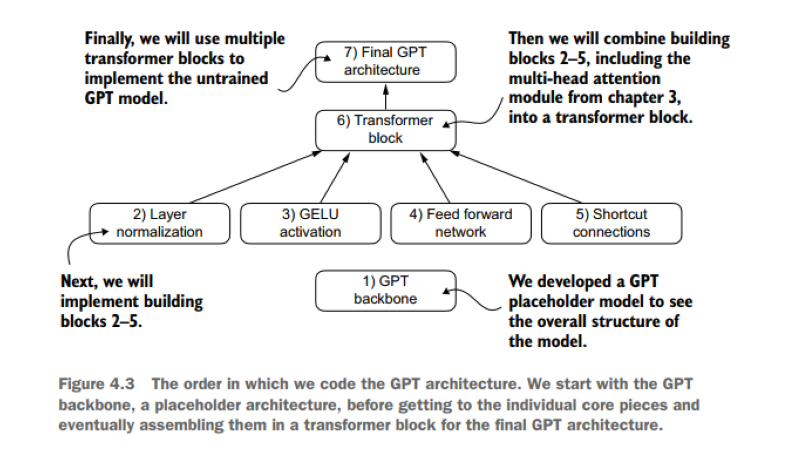

In [7]:
plt.figure(figsize=(10, 14))
img = mpimg.imread(r'C:\Users\yda2\Desktop\llms\plan.png')
plt.imshow(img)
plt.axis('off')
plt.show()

In [8]:
# The main idea behind layer normalization is to adjust the activations (outputs)
# of a neural network layer to have a mean of 0 and a variance of 1, also
# known as unit variance. This adjustment speeds up the convergence to effective
# weights and ensures consistent, reliable training. 

class LayerNorm(torch.nn.Module):
    
    def __init__(self, emb_dim, eps=1e-5):
        super().__init__()
        
        self.eps = eps
        # The scale and shift are two trainable parameters (of the
        # same dimension as the input) that the LLM automatically adjusts during training if it
        # is determined that doing so would improve the model’s performance on its training
        # task. This allows the model to learn appropriate scaling and shifting that best suit the
        # data it is processing.
        self.scale = torch.nn.Parameter(torch.ones(emb_dim))
        self.shift = torch.nn.Parameter(torch.zeros(emb_dim))
        
    def forward(self, x):
        
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        
        return self.scale * norm_x + self.shift

In [9]:
# Historically, the ReLU activation function has been commonly used in deep learning
# due to its simplicity and effectiveness across various neural network architectures.
# However, in LLMs, several other activation functions are employed beyond the traditional ReLU.
# Two notable examples are GELU (Gaussian error linear unit) and SwiGLU (Swish-gated linear unit).

# GELU and SwiGLU are more complex and smooth activation functions incorporating Gaussian and sigmoid-gated linear units, respectively.
# They offer improved performance for deep learning models, unlike the simpler ReLU.
# The GELU activation function can be implemented in several ways; the exact version is defined as
# GELU(x) = x⋅Φ(x), where Φ(x) is the cumulative distribution function of the standard Gaussian distribution.
# In practice, however, it’s common to implement a computationally cheaper approximation
# (the original GPT-2 model was also trained with this approximation, which was found via curve fitting):

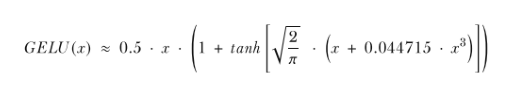

In [10]:
img = mpimg.imread(r'C:\Users\yda2\Desktop\llms\gelu.png')
plt.imshow(img)
plt.axis('off')
plt.show()

In [11]:
class GELU(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) *
            (x + 0.044715 * torch.pow(x, 3))
        ))

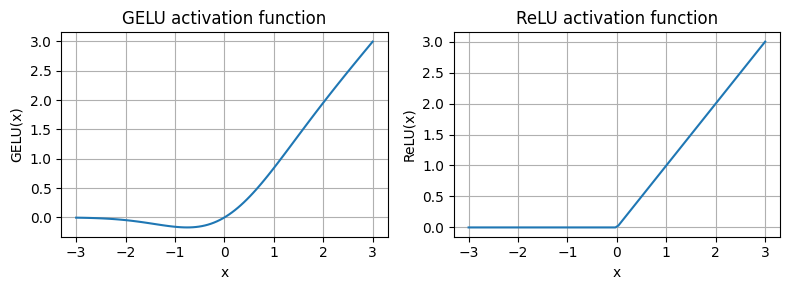

In [12]:
gelu, relu = GELU(), torch.nn.ReLU()
x = torch.linspace(-3, 3, 100)
y_gelu, y_relu = gelu(x), relu(x)

plt.figure(figsize=(8, 3))
for i, (y, label) in enumerate(zip([y_gelu, y_relu], ["GELU", "ReLU"]), 1):
    plt.subplot(1, 2, i)
    plt.plot(x, y)
    plt.title(f"{label} activation function")
    plt.xlabel("x")
    plt.ylabel(f"{label}(x)")
    plt.grid(True)
plt.tight_layout()
plt.show()

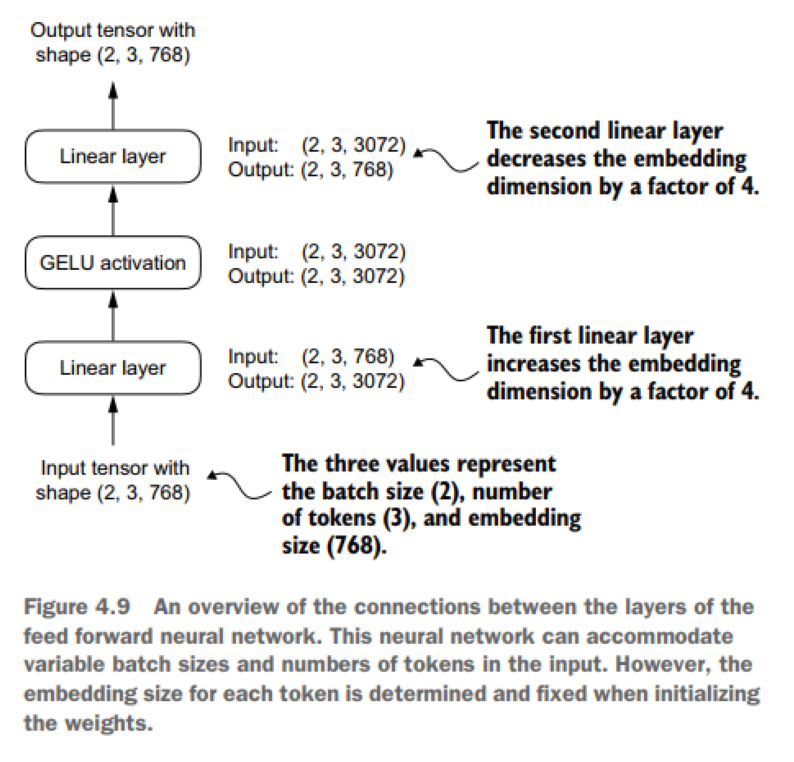

In [13]:
plt.figure(figsize=(10, 18))
img = mpimg.imread(r'C:\Users\yda2\Desktop\llms\linear.png')
plt.imshow(img)
plt.axis('off')
plt.show()

In [14]:
# The FeedForward module is a small neural network consisting of two Linear layers and a GELU activation function.
# The FeedForward module plays a crucial role in enhancing the model’s ability to learn
# from and generalize the data. Although the input and output dimensions of this
# module are the same, it internally expands the embedding dimension into a higherdimensional space through the first linear layer.
# This expansion is followed by a nonlinear GELU activation and then a contraction back to
# the original dimension with the second linear transformation. Such a design allows for the exploration of a richer representation space.

class FeedForward(torch.nn.Module):
    
    def __init__(self, cfg):
        super().__init__()
        self.layers = torch.nn.Sequential(
            torch.nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
            GELU(),
            torch.nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"])
        )
        
    def forward(self, x):
        return self.layers(x)

#### Shortcut connections (skip or residual connections)

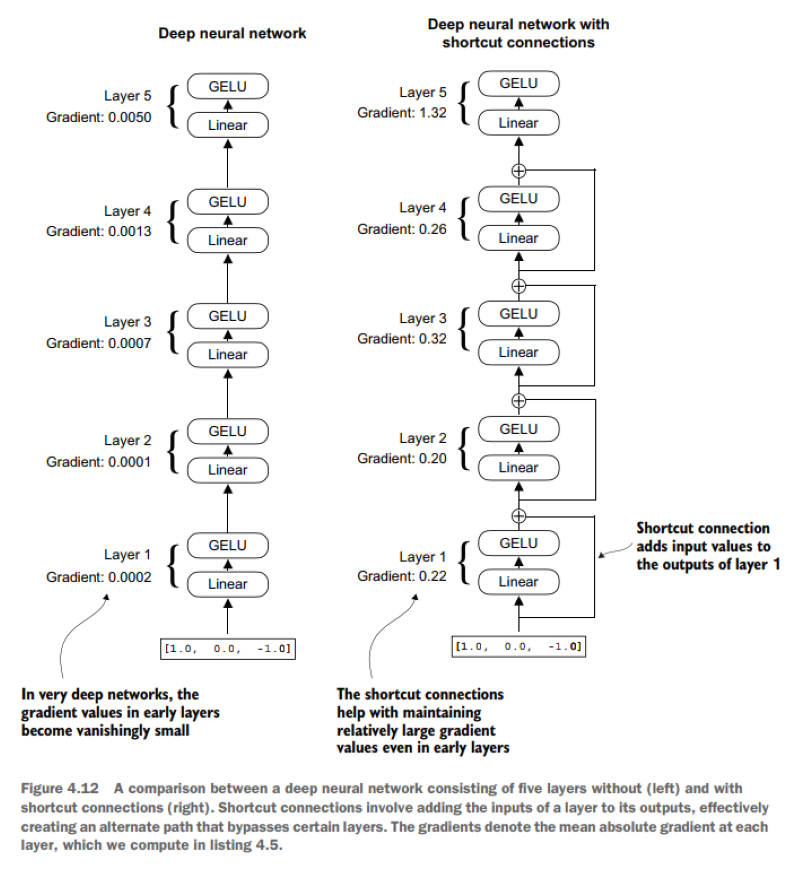

In [15]:
plt.figure(figsize=(10, 20))
img = mpimg.imread(r'C:\Users\yda2\Desktop\llms\short.png')
plt.imshow(img)
plt.axis('off')
plt.show()

In [16]:
class ExampleDeepNeuralNetwork(torch.nn.Module):
    
    def __init__(self, layer_sizes, use_shortcut):
        super().__init__()
        self.use_shortcut = use_shortcut
        self.layers = torch.nn.ModuleList([
            torch.nn.Sequential(torch.nn.Linear(layer_sizes[0], layer_sizes[1]),
                          GELU()),
            torch.nn.Sequential(torch.nn.Linear(layer_sizes[1], layer_sizes[2]),
                          GELU()),
            torch.nn.Sequential(torch.nn.Linear(layer_sizes[2], layer_sizes[3]),
                          GELU()),
            torch.nn.Sequential(torch.nn.Linear(layer_sizes[3], layer_sizes[4]),
                          GELU()),
            torch.nn.Sequential(torch.nn.Linear(layer_sizes[4], layer_sizes[5]),
                          GELU())
        ])

    def forward(self, x):
        
        for layer in self.layers:
            layer_output = layer(x)
            if self.use_shortcut and x.shape == layer_output.shape:
                x = x + layer_output
            else:
                x = layer_output
                
        return x

In [17]:
layer_sizes = [3, 3, 3, 3, 3, 1]
sample_input = torch.tensor([[1., 0., -1.]])
torch.manual_seed(123)
model_without_shortcut = ExampleDeepNeuralNetwork(
    layer_sizes, use_shortcut=False
)

In [18]:
def print_gradients(model, x):
    output = model(x)
    target = torch.tensor([[0.]])
    loss = torch.nn.MSELoss()
    loss = loss(output, target)
    loss.backward()
    for name, param in model.named_parameters():
        if 'weight' in name:
            print(f"{name} has gradient mean of {param.grad.abs().mean().item()}")

In [19]:
print_gradients(model_without_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.00020173587836325169
layers.1.0.weight has gradient mean of 0.0001201116101583466
layers.2.0.weight has gradient mean of 0.0007152041653171182
layers.3.0.weight has gradient mean of 0.001398873864673078
layers.4.0.weight has gradient mean of 0.005049646366387606


In [20]:
# The output of the print_gradients function shows, the gradients become smaller
# as we progress from the last layer (layers.4) to the first layer (layers.0), which is
# a phenomenon called the vanishing gradient problem.

In [21]:
torch.manual_seed(123)
model_with_shortcut = ExampleDeepNeuralNetwork(
    layer_sizes, use_shortcut=True
)
print_gradients(model_with_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.22169792652130127
layers.1.0.weight has gradient mean of 0.20694106817245483
layers.2.0.weight has gradient mean of 0.32896995544433594
layers.3.0.weight has gradient mean of 0.2665732502937317
layers.4.0.weight has gradient mean of 1.3258541822433472


In [22]:
# Now, let’s implement the transformer block, a fundamental building block of GPT and
# other LLM architectures. This block, which is repeated a dozen times in the 124-millionparameter GPT-2 architecture,
# combines several concepts we have previously covered:
# multi-head attention, layer normalization, dropout, feed forward layers, and GELU
# activations. Later, we will connect this transformer block to the remaining parts of the GPT architecture.
# a transformer block combines several components, including the masked multi-head attention module and the FeedForward
# module. When a transformer block processes an input sequence, each element in the sequence (for example, a word or subword token)
# is represented by a fixed-size vector (in this case, 768 dimensions).
# The operations within the transformer block, including multi-head attention and feed forward layers,
# are designed to transform these vectors in a way that preserves their dimensionality.
# The idea is that the self-attention mechanism in the multi-head attention block identifies and analyzes relationships between elements in the input sequence.
# In contrast, the feed forward network modifies the data individually at each position.
# This combination not only enables a more nuanced understanding and processing of the input but
# also enhances the model’s overall capacity for handling complex data patterns.

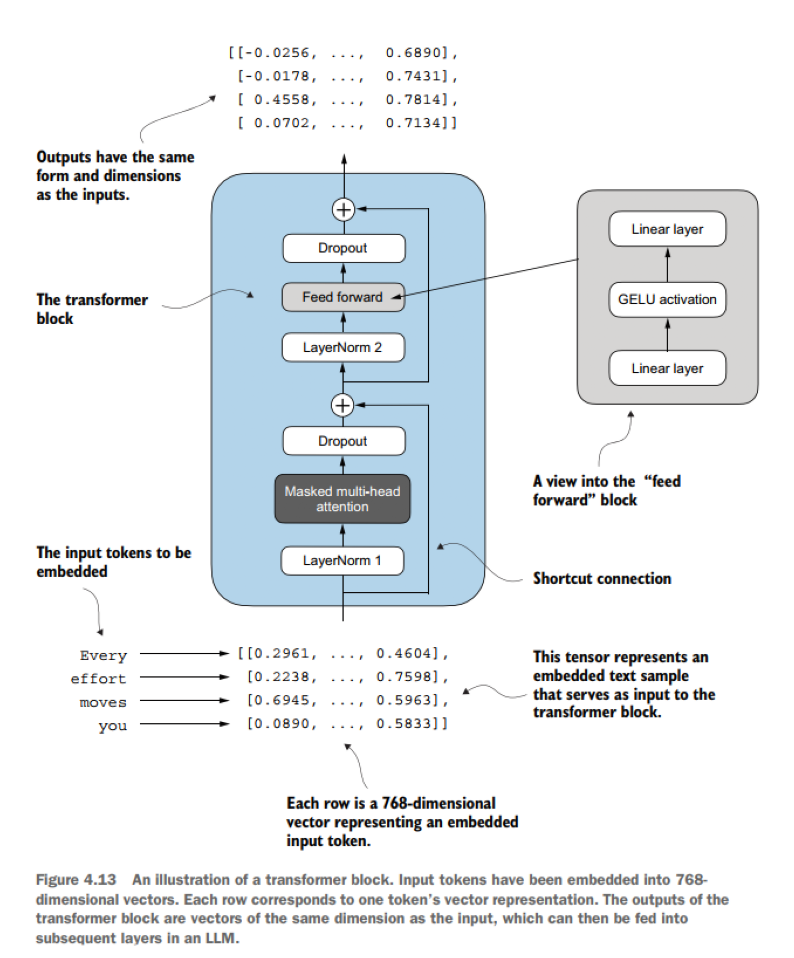

In [23]:
plt.figure(figsize=(10, 20))
img = mpimg.imread(r'C:\Users\yda2\Desktop\llms\trans.png')
plt.imshow(img)
plt.axis('off')
plt.show()

In [24]:
class MultiHeadAttention(torch.nn.Module):
    
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        
        super().__init__()
        assert (d_out % num_heads == 0), "d_out must be divisible by num_heads"
        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads # Reduces the projection dim to match the desired output dim
        self.W_query = torch.nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = torch.nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = torch.nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = torch.nn.Linear(d_out, d_out) # Uses a Linear layer to combine head outputs
        self.dropout = torch.nn.Dropout(dropout)
        self.register_buffer("mask", torch.triu(torch.ones(context_length, context_length), diagonal=1))
        
    def forward(self, x):
        
        # Tensor shape: (b,num_tokens, d_out)
        b, num_tokens, d_in = x.shape
        keys = self.W_key(x)
        queries = self.W_query(x)
        values = self.W_value(x)

        # We implicitly split the matrix by adding a num_heads dimension.
        # Then we unroll the last dim: (b, num_tokens, d_out) -> (b, num_tokens, num_heads, head_dim).
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

        # Transposes from shape (b, num_tokens, num_heads, head_dim) to (b, num_heads, num_tokens, head_dim)
        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)
        
        attn_scores = queries @ keys.transpose(2, 3) # Computes dot product for each head
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens] # Masks truncated to the number of tokens
        attn_scores.masked_fill_(mask_bool, -torch.inf) # Uses the mask to fill attention scores
        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)
        
        context_vec = (attn_weights @ values).transpose(1, 2) # Tensor shape: (b, num_tokens, n_heads, head_dim)
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec) # Adds an optional linear projection
        
        return context_vec

In [25]:
class TransformerBlock(torch.nn.Module):
    
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            num_heads=cfg["n_heads"],
            dropout=cfg["drop_rate"],
            qkv_bias=cfg["qkv_bias"])
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_shortcut = torch.nn.Dropout(cfg["drop_rate"])
        
    def forward(self, x):
        
        shortcut = x
        x = self.norm1(x)
        x = self.att(x)
        x = self.drop_shortcut(x)
        x = x + shortcut
        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut
        
        return x

In [26]:
torch.manual_seed(123)
x = torch.rand(2, 4, 768)
block = TransformerBlock(GPT_CONFIG_124M)
output = block(x)
print("Input shape:", x.shape)
print("Output shape:", output.shape)

Input shape: torch.Size([2, 4, 768])
Output shape: torch.Size([2, 4, 768])


In [27]:
# The preservation of shape throughout the transformer block architecture is not
# incidental but a crucial aspect of its design. This design enables its effective application across a 
# wide range of sequence-to-sequence tasks, where each output vector
# directly corresponds to an input vector, maintaining a one-to-one relationship. 

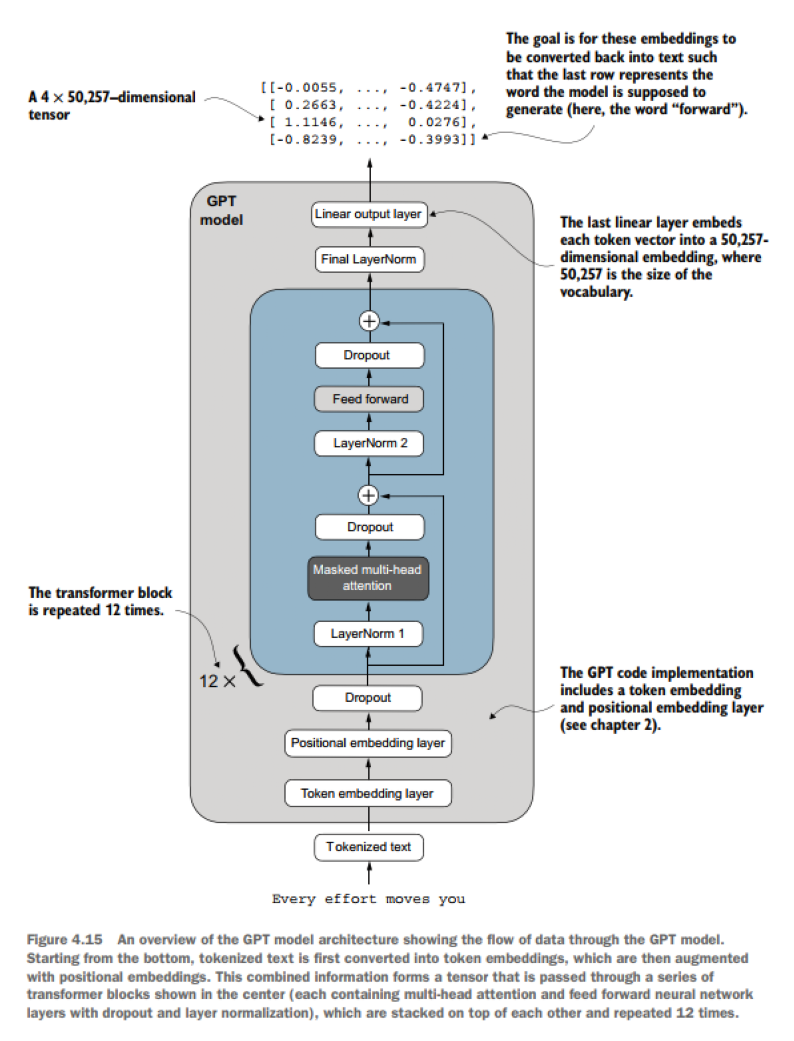

In [28]:
plt.figure(figsize=(10, 20))
img = mpimg.imread(r'C:\Users\yda2\Desktop\llms\gpt.png')
plt.imshow(img)
plt.axis('off')
plt.show()

In [29]:
class GPTModel(torch.nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = torch.nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = torch.nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = torch.nn.Dropout(cfg["drop_rate"])
        self.trf_blocks = torch.nn.Sequential(
            *[TransformerBlock(cfg)
              for _ in range(cfg["n_layers"])]
        )
        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = torch.nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )
    
    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(
            torch.arange(seq_len, device=in_idx.device)
        )
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        
        return logits

In [30]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
out = model(batch)
print("Input batch:\n", batch)
print("\nOutput shape:", out.shape)
print(out)

Input batch:
 tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])

Output shape: torch.Size([2, 4, 50257])
tensor([[[ 0.1381,  0.0077, -0.1963,  ..., -0.0222, -0.1060,  0.1717],
         [ 0.3865, -0.8408, -0.6564,  ..., -0.5163,  0.2369, -0.3357],
         [ 0.6989, -0.1829, -0.1631,  ...,  0.1472, -0.6504, -0.0056],
         [-0.4290,  0.1669, -0.1258,  ...,  1.1579,  0.5303, -0.5549]],

        [[ 0.1094, -0.2894, -0.1467,  ..., -0.0557,  0.2911, -0.2824],
         [ 0.0882, -0.3552, -0.3527,  ...,  1.2930,  0.0053,  0.1898],
         [ 0.6091,  0.4702, -0.4094,  ...,  0.7688,  0.3787, -0.1974],
         [-0.0612, -0.0737,  0.4751,  ...,  1.2463, -0.3834,  0.0609]]],
       grad_fn=<UnsafeViewBackward0>)


In [31]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params:,}")

Total number of parameters: 163,009,536


In [32]:
# Earlier, we spoke of initializing a 124-million-parameter GPT model, so why is the actual number of parameters 163 million?
# The reason is a concept called weight tying, which was used in the original GPT-2
# architecture. It means that the original GPT-2 architecture reuses the weights from
# the token embedding layer in its output layer. 
print("Token embedding layer shape:", model.tok_emb.weight.shape)
print("Output layer shape:", model.out_head.weight.shape)

Token embedding layer shape: torch.Size([50257, 768])
Output layer shape: torch.Size([50257, 768])


In [33]:
total_params_gpt2 = (
    total_params - sum(p.numel()
                       for p in model.out_head.parameters())
)
print(f"Number of trainable parameters "
      f"considering weight tying: {total_params_gpt2:,}"
)

Number of trainable parameters considering weight tying: 124,412,160


In [34]:
for name, param in model.state_dict().items():
    print(name)

tok_emb.weight
pos_emb.weight
trf_blocks.0.att.mask
trf_blocks.0.att.W_query.weight
trf_blocks.0.att.W_key.weight
trf_blocks.0.att.W_value.weight
trf_blocks.0.att.out_proj.weight
trf_blocks.0.att.out_proj.bias
trf_blocks.0.ff.layers.0.weight
trf_blocks.0.ff.layers.0.bias
trf_blocks.0.ff.layers.2.weight
trf_blocks.0.ff.layers.2.bias
trf_blocks.0.norm1.scale
trf_blocks.0.norm1.shift
trf_blocks.0.norm2.scale
trf_blocks.0.norm2.shift
trf_blocks.1.att.mask
trf_blocks.1.att.W_query.weight
trf_blocks.1.att.W_key.weight
trf_blocks.1.att.W_value.weight
trf_blocks.1.att.out_proj.weight
trf_blocks.1.att.out_proj.bias
trf_blocks.1.ff.layers.0.weight
trf_blocks.1.ff.layers.0.bias
trf_blocks.1.ff.layers.2.weight
trf_blocks.1.ff.layers.2.bias
trf_blocks.1.norm1.scale
trf_blocks.1.norm1.shift
trf_blocks.1.norm2.scale
trf_blocks.1.norm2.shift
trf_blocks.2.att.mask
trf_blocks.2.att.W_query.weight
trf_blocks.2.att.W_key.weight
trf_blocks.2.att.W_value.weight
trf_blocks.2.att.out_proj.weight
trf_blocks.2.

In [35]:
# calculating the memory requirements for the 163 million parameters in our GPTModel
# assuming each parameter is a 32-bit float taking up 4 bytes. 

total_size_bytes = total_params * 4
total_size_mb = total_size_bytes / (1024 * 1024)
print(f"Total size of the model: {total_size_mb:.2f} MB")

Total size of the model: 621.83 MB


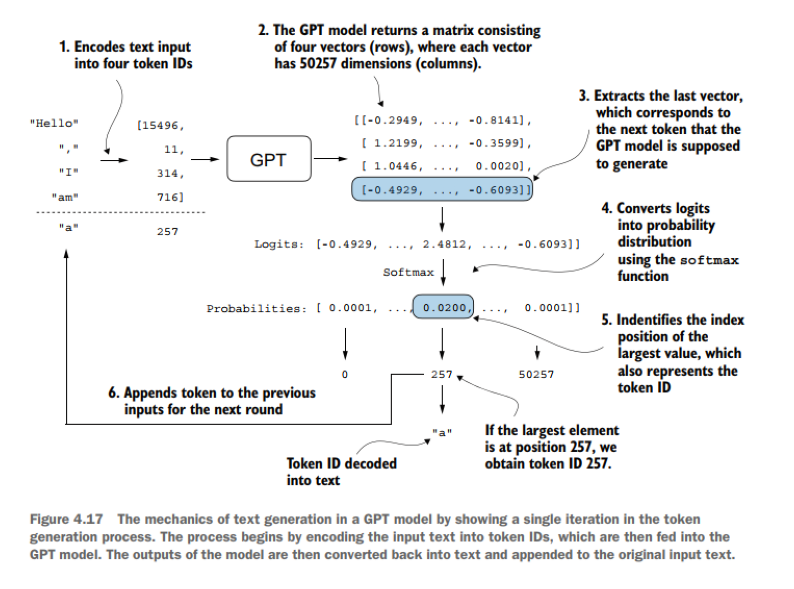

In [36]:
plt.figure(figsize=(10, 10))
img = mpimg.imread(r'C:\Users\yda2\Desktop\llms\tok.png')
plt.imshow(img)
plt.axis('off')
plt.show()

In [38]:
# A function for the GPT model to generate text

# To code the generate_text_simple function, we use a softmax function to convert the logits into a probability distribution from which we identify the position with
# the highest value via torch.argmax. The softmax function is monotonic, meaning it
# preserves the order of its inputs when transformed into outputs. So, in practice, the
# softmax step is redundant since the position with the highest score in the softmax output tensor is the same position in the logit tensor.
# In other words, we could apply the torch.argmax function to the logits tensor directly and get identical results. However,
# I provide the code for the conversion to illustrate the full process of transforming logits to probabilities, 
# which can add additional intuition so that the model generates the most likely next token, which is known as greedy decoding.

def generate_text_simple(model, idx, max_new_tokens, context_size):
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]
        probas = torch.softmax(logits, dim=-1)
        idx_next = torch.argmax(probas, dim=-1, keepdim=True)
        idx = torch.cat((idx, idx_next), dim=1)
    return idx

In [43]:
start_context = "Hello, I am"
encoded = tokenizer.encode(start_context)
print("encoded:", encoded)
encoded_tensor = torch.tensor(encoded).unsqueeze(0) # Adds batch dimension
print("encoded_tensor.shape:", encoded_tensor.shape)
print("encoded_tensor.shape:", encoded_tensor)

encoded: [15496, 11, 314, 716]
encoded_tensor.shape: torch.Size([1, 4])
encoded_tensor.shape: tensor([[15496,    11,   314,   716]])


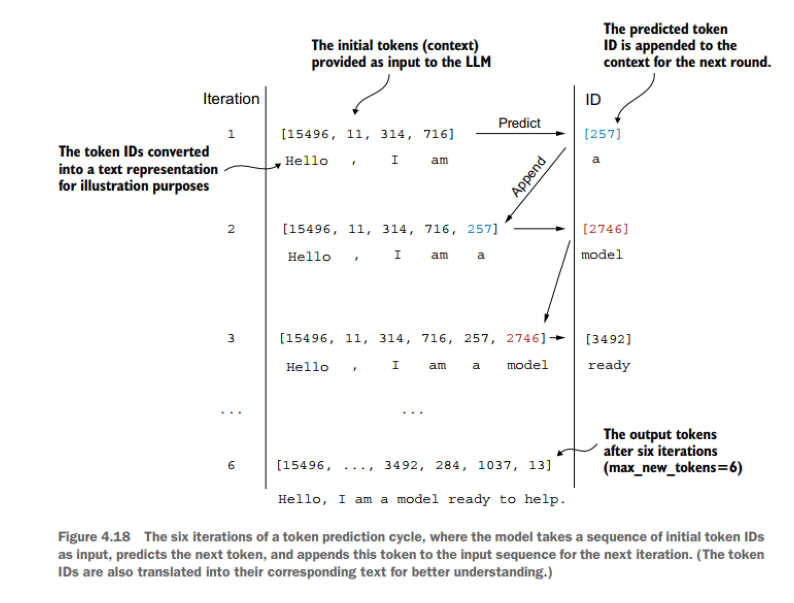

In [45]:
plt.figure(figsize=(10, 8))
img = mpimg.imread(r'C:\Users\yda2\Desktop\llms\tok1.png')
plt.imshow(img)
plt.axis('off')
plt.show()

In [46]:
model.eval() # Disables dropout since we are not training the model
out = generate_text_simple(
model=model,
idx=encoded_tensor,
max_new_tokens=6,
context_size=GPT_CONFIG_124M["context_length"]
)
print("Output:", out)
print("Output length:", len(out[0]))

Output: tensor([[15496,    11,   314,   716, 27018, 24086, 47843, 30961, 42348,  7267]])
Output length: 10


In [48]:
decoded_text = tokenizer.decode(out.squeeze(0).tolist()) # Using the .decode method of the tokenizer, we can convert the IDs back into text
print(decoded_text)

Hello, I am Featureiman Byeswickattribute argue
